# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run18', 'ORACLE.run144', 'ORACLE.run126', 'ORACLE.run120', 'ORACLE.run138', 'ORACLE.run132', 'ORACLE.run150', 'ORACLE.run114'}


{'Wisig_1', 'Wisig_2', 'Wisig_3', 'Wisig_4'}


tensor([[[ 1.3646,  0.2454,  1.0112,  ..., -0.3043, -0.9228, -0.2945],
         [ 0.3142,  0.4614, -0.0393,  ...,  1.2566,  0.2552, -1.2762]],

        [[ 0.6683,  1.0614, -1.4840,  ..., -1.8182, -0.5602,  1.0319],
         [ 0.5995,  0.5504, -0.1671,  ..., -1.1990, -0.4226, -0.2260]],

        [[-0.8064, -0.1854,  0.7508,  ...,  0.1761, -0.2781, -0.1946],
         [ 0.5098,  0.6488,  0.8527,  ..., -0.2410,  0.8620, -1.2513]],

        ...,

        [[ 0.5589, -0.2290, -1.0078,  ..., -0.1191, -0.7604, -1.4933],
         [ 0.0550,  0.1741,  0.8795,  ...,  0.8429, -0.1283,  1.2826]],

        [[ 0.3345,  0.6504, -0.6875,  ...,  2.0905,  1.3101,  0.4460],
         [ 0.7433,  0.2137, -0.3066,  ...,  1.0313,  0.4738,  0.6132]],

        [[ 0.2057, -0.5544, -1.2518,  ..., -0.3577,  0.7153,  1.0730],
         [ 0.4381, -0.7600, -1.4396,  ...,  0.3666, -0.7690,  1.5826]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.6068, train_label_loss: 2.7620, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3378.1643, train_label_loss: 2.0336, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3757.5313, train_label_loss: 0.8808, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3885.7758, train_label_loss: 0.6683, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3858.5267, train_label_loss: 1.2099, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 3911.2316, train_label_loss: 0.9112, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3898.9046, train_label_loss: 0.5078, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3209.0750, train_label_loss: 0.4631, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3401.2169, train_label_loss: 0.6169, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3302.3710, train_label_loss: 1.4571, 


epoch: 1, source_val_acc_label: 0.6357, target_val_acc_label: 0.6760, source_val_label_loss: 1.0081, target_val_label_loss: 5.1106, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.7330, train_label_loss: 0.7598, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3004.9267, train_label_loss: 0.5723, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 2998.8701, train_label_loss: 1.3428, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 2989.2909, train_label_loss: 0.6241, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 2962.1873, train_label_loss: 0.4782, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3174.5369, train_label_loss: 0.7703, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3537.7697, train_label_loss: 1.0998, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 3213.9573, train_label_loss: 1.1130, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3435.8921, train_label_loss: 1.1018, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3504.1918, train_label_loss: 1.1910, 


epoch: 2, source_val_acc_label: 0.6771, target_val_acc_label: 0.7098, source_val_label_loss: 0.8555, target_val_label_loss: 6.4000, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.7313, train_label_loss: 0.5992, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 2995.1896, train_label_loss: 1.1362, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3004.3570, train_label_loss: 1.0752, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3005.3432, train_label_loss: 0.6152, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 2992.3284, train_label_loss: 0.5232, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 3149.1435, train_label_loss: 0.7069, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 3437.5383, train_label_loss: 0.9676, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 3191.9131, train_label_loss: 0.9414, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3420.8993, train_label_loss: 0.9451, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3481.5712, train_label_loss: 0.5931, 


epoch: 3, source_val_acc_label: 0.7061, target_val_acc_label: 0.7319, source_val_label_loss: 0.7965, target_val_label_loss: 7.7189, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.7353, train_label_loss: 0.3726, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3025.3183, train_label_loss: 0.5024, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3021.5207, train_label_loss: 1.1172, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3013.9098, train_label_loss: 0.8416, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 2982.5243, train_label_loss: 0.5112, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3122.5091, train_label_loss: 1.2326, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3453.5035, train_label_loss: 1.1392, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3197.7476, train_label_loss: 0.4427, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3332.3217, train_label_loss: 0.6367, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3547.0797, train_label_loss: 0.6533, 


epoch: 4, source_val_acc_label: 0.7148, target_val_acc_label: 0.7440, source_val_label_loss: 0.7721, target_val_label_loss: 7.9692, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.7357, train_label_loss: 0.5075, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 2989.6221, train_label_loss: 0.7758, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 2984.0725, train_label_loss: 0.6491, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 2978.5052, train_label_loss: 0.4668, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3019.5907, train_label_loss: 0.6072, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3157.1433, train_label_loss: 0.8717, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3442.7317, train_label_loss: 0.6495, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 3171.6480, train_label_loss: 0.3684, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3338.0094, train_label_loss: 0.6973, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3578.0668, train_label_loss: 0.5935, 


epoch: 5, source_val_acc_label: 0.7219, target_val_acc_label: 0.7500, source_val_label_loss: 0.7642, target_val_label_loss: 8.8432, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.7326, train_label_loss: 0.3960, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3030.2565, train_label_loss: 0.6520, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 2997.9400, train_label_loss: 0.7552, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 3048.6301, train_label_loss: 1.0837, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3026.0788, train_label_loss: 0.6116, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3112.4832, train_label_loss: 0.7277, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3447.0393, train_label_loss: 0.6334, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3175.6008, train_label_loss: 0.3959, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3259.2472, train_label_loss: 0.5836, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3569.3300, train_label_loss: 0.5489, 


epoch: 6, source_val_acc_label: 0.7263, target_val_acc_label: 0.7650, source_val_label_loss: 0.7647, target_val_label_loss: 9.0820, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.7397, train_label_loss: 0.9812, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 2979.3709, train_label_loss: 0.4911, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3008.2462, train_label_loss: 0.3928, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 2988.4657, train_label_loss: 0.4478, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 2968.1931, train_label_loss: 0.2845, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3108.8136, train_label_loss: 0.6246, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 3429.9778, train_label_loss: 0.3510, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 3442.0382, train_label_loss: 0.3014, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3592.9307, train_label_loss: 0.5810, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 4046.9800, train_label_loss: 0.5326, 


epoch: 7, source_val_acc_label: 0.7264, target_val_acc_label: 0.7751, source_val_label_loss: 0.7513, target_val_label_loss: 8.6691, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.8823, train_label_loss: 0.2341, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3933.5616, train_label_loss: 0.4630, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3979.0930, train_label_loss: 0.3781, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 3864.5065, train_label_loss: 0.8440, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3834.5448, train_label_loss: 0.6660, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3949.5228, train_label_loss: 0.4194, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3682.3288, train_label_loss: 0.7646, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3010.3341, train_label_loss: 0.3897, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3275.7507, train_label_loss: 0.6363, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3969.3743, train_label_loss: 0.3024, 


epoch: 8, source_val_acc_label: 0.7302, target_val_acc_label: 0.7799, source_val_label_loss: 0.7569, target_val_label_loss: 9.5194, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.7561, train_label_loss: 0.3206, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3377.8379, train_label_loss: 0.3503, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3010.6341, train_label_loss: 0.3290, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 3084.8515, train_label_loss: 0.7160, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3353.2324, train_label_loss: 0.4793, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3118.8543, train_label_loss: 0.3713, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 2996.7471, train_label_loss: 0.3835, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3301.1619, train_label_loss: 0.4019, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3491.6951, train_label_loss: 0.4042, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3570.8341, train_label_loss: 0.4803, 


epoch: 9, source_val_acc_label: 0.7283, target_val_acc_label: 0.7819, source_val_label_loss: 0.7754, target_val_label_loss: 9.6977, 


New best


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.8113, train_label_loss: 0.5416, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3420.9844, train_label_loss: 0.3729, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3424.4885, train_label_loss: 0.2245, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3411.4497, train_label_loss: 0.8177, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3384.2825, train_label_loss: 0.2709, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3821.5223, train_label_loss: 0.4593, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3908.7448, train_label_loss: 0.2012, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3842.3921, train_label_loss: 0.2304, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 4040.7990, train_label_loss: 0.2351, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 4645.1163, train_label_loss: 0.4816, 


epoch: 10, source_val_acc_label: 0.7296, target_val_acc_label: 0.7866, source_val_label_loss: 0.7892, target_val_label_loss: 10.3294, 


New best


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.9759, train_label_loss: 0.4035, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3011.7959, train_label_loss: 0.3967, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3173.5676, train_label_loss: 0.1708, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3398.3418, train_label_loss: 0.4674, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 2968.4438, train_label_loss: 0.1532, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3045.2776, train_label_loss: 0.3596, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3400.8841, train_label_loss: 0.2548, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3202.7139, train_label_loss: 0.3261, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3137.5325, train_label_loss: 0.3673, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3698.5476, train_label_loss: 0.6248, 


epoch: 11, source_val_acc_label: 0.7269, target_val_acc_label: 0.7938, source_val_label_loss: 0.7981, target_val_label_loss: 10.5069, 


New best


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.7834, train_label_loss: 0.3944, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 3397.4308, train_label_loss: 0.3803, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 3250.3116, train_label_loss: 0.4701, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3015.2359, train_label_loss: 0.3543, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 3200.9049, train_label_loss: 0.3315, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 3453.4313, train_label_loss: 0.6873, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 3012.9620, train_label_loss: 0.1015, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 3018.1520, train_label_loss: 0.0953, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 3520.5064, train_label_loss: 0.4367, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3885.4696, train_label_loss: 0.3864, 


epoch: 12, source_val_acc_label: 0.7284, target_val_acc_label: 0.7891, source_val_label_loss: 0.8204, target_val_label_loss: 11.1214, 


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.8725, train_label_loss: 0.3404, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 3393.9395, train_label_loss: 0.5471, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 3667.2544, train_label_loss: 0.3564, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 3932.2470, train_label_loss: 0.6278, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3845.3016, train_label_loss: 0.4632, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 3957.9947, train_label_loss: 0.0720, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 3876.7439, train_label_loss: 0.2808, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 3012.4473, train_label_loss: 0.4707, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 3061.0989, train_label_loss: 0.4296, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 3721.5427, train_label_loss: 0.2643, 


epoch: 13, source_val_acc_label: 0.7243, target_val_acc_label: 0.7935, source_val_label_loss: 0.8476, target_val_label_loss: 11.3316, 


epoch: 14, [batch: 1 / 33600], examples_per_second: 0.7777, train_label_loss: 0.2317, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 3477.8115, train_label_loss: 0.1284, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 3005.9548, train_label_loss: 0.1250, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 3000.1304, train_label_loss: 0.5937, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 3388.8741, train_label_loss: 0.1871, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 3204.4054, train_label_loss: 0.1146, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 2991.8276, train_label_loss: 0.2966, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 3177.0092, train_label_loss: 0.4558, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 3525.9819, train_label_loss: 0.1101, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 3449.7622, train_label_loss: 0.6533, 


epoch: 14, source_val_acc_label: 0.7252, target_val_acc_label: 0.7950, source_val_label_loss: 0.8593, target_val_label_loss: 11.7241, 


New best


epoch: 15, [batch: 1 / 33600], examples_per_second: 0.8282, train_label_loss: 0.2969, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 3483.0831, train_label_loss: 0.5659, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 3413.2792, train_label_loss: 0.4970, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 3392.9659, train_label_loss: 0.1035, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 3410.0689, train_label_loss: 0.1090, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 3722.5319, train_label_loss: 0.1950, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 3946.0392, train_label_loss: 0.2525, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 3952.6161, train_label_loss: 0.2412, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 3940.8566, train_label_loss: 0.0884, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 4354.2551, train_label_loss: 0.3339, 


epoch: 15, source_val_acc_label: 0.7205, target_val_acc_label: 0.7915, source_val_label_loss: 0.8922, target_val_label_loss: 12.1495, 


epoch: 16, [batch: 1 / 33600], examples_per_second: 1.0678, train_label_loss: 0.2278, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 3258.0331, train_label_loss: 0.4807, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 2982.2061, train_label_loss: 0.1035, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 2987.9909, train_label_loss: 0.4476, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 3011.3579, train_label_loss: 0.1181, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 2978.0261, train_label_loss: 0.2182, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 2973.4424, train_label_loss: 0.0343, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 2990.9529, train_label_loss: 0.5275, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 3003.8083, train_label_loss: 0.1529, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 3379.1650, train_label_loss: 0.1161, 


epoch: 16, source_val_acc_label: 0.7219, target_val_acc_label: 0.7910, source_val_label_loss: 0.9052, target_val_label_loss: 12.5591, 


epoch: 17, [batch: 1 / 33600], examples_per_second: 0.8057, train_label_loss: 0.2565, 


epoch: 17, [batch: 3360 / 33600], examples_per_second: 3243.9635, train_label_loss: 0.4614, 


epoch: 17, [batch: 6720 / 33600], examples_per_second: 3060.1261, train_label_loss: 0.2960, 


epoch: 17, [batch: 10080 / 33600], examples_per_second: 2985.5656, train_label_loss: 0.4701, 


epoch: 17, [batch: 13440 / 33600], examples_per_second: 2989.8912, train_label_loss: 0.3089, 


epoch: 17, [batch: 16800 / 33600], examples_per_second: 3012.4453, train_label_loss: 0.1374, 


epoch: 17, [batch: 20160 / 33600], examples_per_second: 2987.4403, train_label_loss: 0.3731, 


epoch: 17, [batch: 23520 / 33600], examples_per_second: 2990.1386, train_label_loss: 0.1797, 


epoch: 17, [batch: 26880 / 33600], examples_per_second: 2978.6702, train_label_loss: 0.2976, 


epoch: 17, [batch: 30240 / 33600], examples_per_second: 3378.4694, train_label_loss: 0.2923, 


epoch: 17, source_val_acc_label: 0.7245, target_val_acc_label: 0.7903, source_val_label_loss: 0.9547, target_val_label_loss: 13.4034, 


epoch: 18, [batch: 1 / 33600], examples_per_second: 0.8254, train_label_loss: 0.1622, 


epoch: 18, [batch: 3360 / 33600], examples_per_second: 3159.6746, train_label_loss: 0.2659, 


epoch: 18, [batch: 6720 / 33600], examples_per_second: 2999.3334, train_label_loss: 0.4750, 


epoch: 18, [batch: 10080 / 33600], examples_per_second: 2995.2293, train_label_loss: 0.3701, 


epoch: 18, [batch: 13440 / 33600], examples_per_second: 2960.1523, train_label_loss: 0.0587, 


epoch: 18, [batch: 16800 / 33600], examples_per_second: 3012.5492, train_label_loss: 0.0274, 


epoch: 18, [batch: 20160 / 33600], examples_per_second: 2985.8231, train_label_loss: 0.5993, 


epoch: 18, [batch: 23520 / 33600], examples_per_second: 2996.3614, train_label_loss: 0.2583, 


epoch: 18, [batch: 26880 / 33600], examples_per_second: 3018.5852, train_label_loss: 0.2527, 


epoch: 18, [batch: 30240 / 33600], examples_per_second: 3347.3735, train_label_loss: 0.1527, 


epoch: 18, source_val_acc_label: 0.7206, target_val_acc_label: 0.7915, source_val_label_loss: 0.9777, target_val_label_loss: 13.6926, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

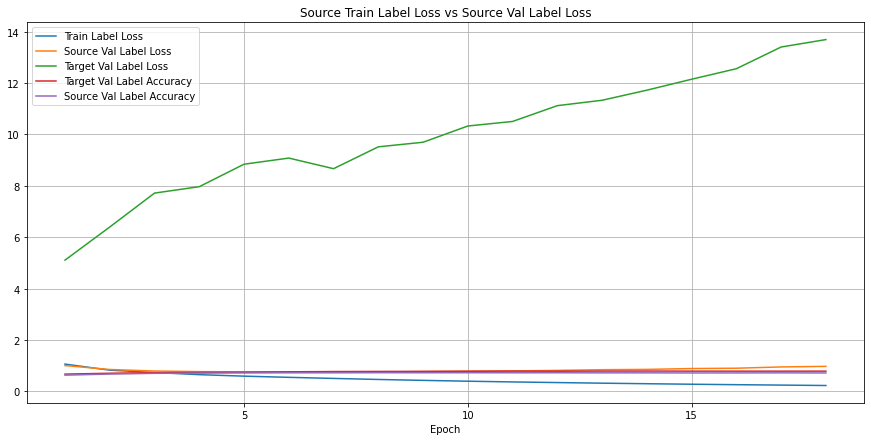

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

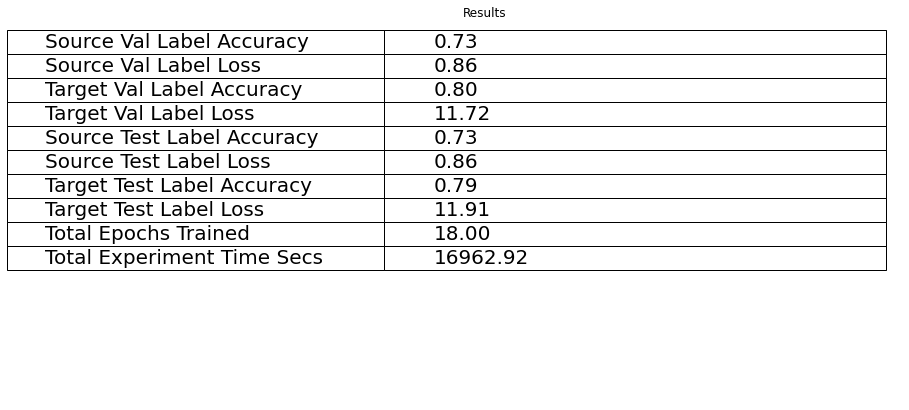

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

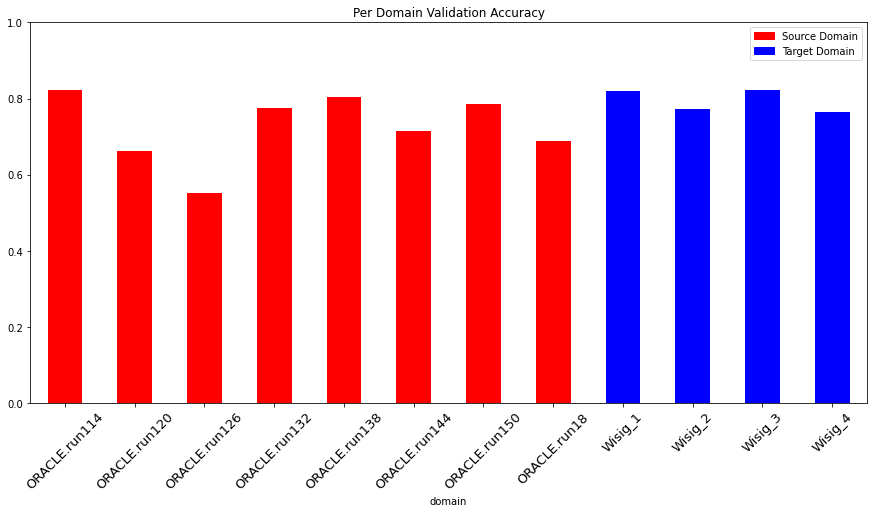

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7254622395833333 Target Test Label Accuracy: 0.7937306501547987
Source Val Label Accuracy: 0.7251953125 Target Val Label Accuracy: 0.7950435586061246


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL